In [1]:
import pandas as pd
import numpy as np
import feather
import re
import folium
from shapely.geometry import MultiLineString
from shapely import geometry, ops
pd.options.display.max_columns = None

# Load and Clean the Data

## Ticket Data for 2020 and 2021

- Load preprocessed files from feather

In [2]:
ticket20 = feather.read_dataframe('ticket_2020.feather')
# ticket19 = feather.read_dataframe('ticket_2019.feather')

### Peek at the Data

In [3]:
ticket20.sample(5)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
3377470,4666101718,HRK9894,NY,PAS,09/16/2019 12:00:00 AM,36,4DSD,AUDI,V,0,0,0,0,NaN,0,0,0,None,None,0819A,None,BK,None,None,NB CONEY ISLAND AVE,@ KERMIT PL,0,1180,B,T,None,None,None,BK,NaN,2017,None,0,None,PHTO SCHOOL ZN SPEED VIOLATION,NaN,NaN,NaN
6797098,8770326447,2601910,IN,PAS,12/12/2019 12:00:00 AM,74,DELV,INTER,T,18190,27790,24890,88880088,19.0,19,19,365335,T103,D,0908A,None,NY,F,129,E 60th St,None,0,408,C,None,YYYYYYY,None,None,WHITE,NaN,0,None,0,07,None,NaN,NaN,NaN
3510124,8746878324,FXT9937,NY,PAS,09/19/2019 12:00:00 AM,14,SUBN,ME/BE,T,35310,14510,15710,20200730,20.0,20,20,357090,T103,I,1049A,None,NY,O,40,W 77th St,None,0,408,C,None,YYYYY,0900A,0300P,BK,NaN,2002,None,0,41,None,NaN,NaN,NaN
2986273,8723536949,365A169,VT,PAS,09/07/2019 12:00:00 AM,69,VAN,INTER,T,10510,34290,34310,88880088,13.0,13,13,355418,T102,H,0822A,None,NY,F,775,6th Ave,None,0,408,H1,None,YYYYYY,0700A,0700P,YELLO,NaN,0,None,0,22,None,NaN,NaN,NaN
5072286,8770957654,6SSL570,CA,PAS,10/28/2019 12:00:00 AM,17,2DSD,FORD,T,0,0,0,20190088,46.0,46,46,367961,T201,H,1226P,None,BX,I,W,Bathgate Ave,10ft N/of E 189th St,0,408,E5,None,SCHOOL,0700A,0400P,WHITE,NaN,0,None,0,60,None,NaN,NaN,NaN


In [4]:
ticket20.shape

(12495734, 43)

In [5]:
# ticket19.sample(5)

In [6]:
# ticket19.shape

### Step 1 - Drop Missing/Blank Street Codes (for now)

Since we plan to use street codes to get a location of each ticket, we drop every ticket with no street code in Street Code1, Street Code2, Street Code3 (note: these represent ~30% of the 12mn rows - not an insignificant amount of data - potentially can group by Violation Location/Precinct perhaps?)

In [7]:
ticket20_clean=ticket20[(ticket20['Street Code1']!=0) | (ticket20['Street Code2']!=0) | (ticket20['Street Code3']!=0)].copy()

### Step 2 - Add Leading Zeros Back to Street Codes - ensure 5 digit

In [8]:
ticket20_clean['Street Code1'] = ticket20_clean['Street Code1'].apply('{0:0>5}'.format)
ticket20_clean['Street Code2'] = ticket20_clean['Street Code2'].apply('{0:0>5}'.format)
ticket20_clean['Street Code3'] = ticket20_clean['Street Code3'].apply('{0:0>5}'.format)

In [9]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN


In [10]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'K   F', 'ST',
       'QUEEN', 'KINGS', 'QNS'], dtype=object)

### Step 3 - Map Violation County to Borough Code

Code Borough InTicket

- 1 Manhattan NY/MN
- 2 Bronx BX
- 3 Brooklyn K/BK/KINGS
- 4 Queens Q/QN/QUEEN/QNS
- 5 Staten Island R/ST
- 6 Nassau County
- 7 Westchester
- 8 New Jersey

Drop the 'K   F' - only one data point

In [11]:
# ticket20_clean[ticket20_clean['Violation County']=='K   F']
ticket20_clean.drop([94098],inplace=True)

In [12]:
ticket20_clean['Violation County'].unique()

array(['K', 'Q', 'BX', None, 'NY', 'R', 'BK', 'QN', 'MN', 'ST', 'QUEEN',
       'KINGS', 'QNS'], dtype=object)

In [13]:
boro_dict = {'NY':'1',
             'MN':'1',
             'BX':'2',
             'K':'3',
             'BK':'3',
             'KINGS':'3',
             'Q':'4',
             'QN':'4',
             'QUEEN':'4',
             'QNS':'4',
             'R':'5',
             'ST':'5',
             'None':'0'
            }

In [14]:
ticket20_clean['Boro Code'] = ticket20_clean['Violation County'].map(boro_dict)
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3


### Step 4 - Create lookup String to get Street Names

In [15]:
ticket20_clean['Street1LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code1']
ticket20_clean['Street2LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code2']
ticket20_clean['Street3LU'] = 'PF'+ticket20_clean['Boro Code']+ticket20_clean['Street Code3']

In [16]:
ticket20_clean.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130


## Load Street Names DB and Create Lookup to StreetName Dict

In [17]:
stnames = pd.read_csv('/Users/stuartong/uberticketsyelp/Data/snd20d/snd20Dcow.txt')
stnames.columns=['Raw']

# from SND_metadata.pdf - location of stnames and Lookup prefixes
stnames['Street Name']=stnames['Raw'].str[2:34].str.strip()
stnames['Lookup']=stnames['Raw'].str[34:42]
stnames_dict= pd.Series(stnames['Street Name'].values,index=stnames['Lookup']).to_dict()

In [18]:
stnames

,Raw,Street Name,Lookup
0,11 0 BOND STREET PF1006890101...,0 BOND STREET,PF100689
1,11 1 AVENUE PF1100100101...,1 AVENUE,PF110010
2,11 1 AVENUE LOOP PF1317200102...,1 AVENUE LOOP,PF131720
3,11 1 AVENUE LOWER NB ROADBED VF1100100701...,1 AVENUE LOWER NB ROADBED,VF110010
4,11 1 AVENUE NORTHBOUND ROADBED VF1100100601...,1 AVENUE NORTHBOUND ROADBED,VF110010
...,...,...,...
106756,15ZENI PLACE VS5341050102...,ZENI PLACE,VS534105
106757,15ZEPHYR AVENUE PF5566960101...,ZEPHYR AVENUE,PF556696
106758,15ZEV PLACE PF5703670101...,ZEV PLACE,PF570367
106759,15ZOE STREET PF5567150101...,ZOE STREET,PF556715


In [19]:
stnames_dict

{'PF100689': '0 BOND STREET',
 'PF110010': '1 AVENUE',
 'PF131720': '1 AVENUE LOOP',
 'VF110010': 'VETERANS WAY',
 'PF101127': '1 AVENUE TUNNEL',
 'PF113655': '1 DRIVE',
 'VS112740': '1 PARK',
 'VS100058': 'PRECINCT    1 STATIONHOUSE',
 'PF110015': '1 PLACE',
 'PF100058': '1 PRECINCT STATIONHOUSE',
 'VS101232': 'FIRST ST GARDEN',
 '        ': 'TREMONT AVENUE WB ROADBED',
 'VS101346': 'ONE VANDERBILT',
 'VS111115': 'WSH',
 'PF110110': '2 AVENUE',
 'VF110110': 'YITZHAK RABIN WAY',
 'VS110780': 'SECOND AVENUE NB ENTRANCE HRD',
 'VF127310': 'WHITE PLAINS ROAD LINE',
 'VS132622': 'TWO BRIDGES URA SITE    7 HOUSE',
 'PF113470': '2 DRIVE',
 'PF110115': '2 PLACE',
 'VS120490': 'ROOSEVELT DRIVE SB ROADBED',
 'VF197710': '3 AVE BRDG PED AND BIKE PATH',
 'VS197510': 'WEST INTREPID MUSEUM PED OVPS',
 'VF197510': 'WEST 178-179 STREET PED OVERPASS',
 'PF110210': '3 AVENUE',
 'VS197850': 'THIRD AVENUE BRIDGE APPROACH',
 'VS197710': 'THIRD AVENUE BRIDGE BIKE PATH',
 'VS110785': 'THIRD AVENUE BRIDGE SB

### Step 5 - Get Street Names 

In [20]:
ticket20_clean['Street1'] = ticket20_clean['Street1LU'].map(stnames_dict)
ticket20_clean['Street2'] = ticket20_clean['Street2LU'].map(stnames_dict)
ticket20_clean['Street3'] = ticket20_clean['Street3LU'].map(stnames_dict)

In [21]:
ticket20_clean.head(10)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280,43 STREET,2 AVENUE,3 AVENUE
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110,UNION STREET,PORTAL STREET,RALPH AVENUE
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730,DIVISION AVENUE,WILSON STREET,MARCY AVENUE
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET
5,1440657920,KDG0693,PA,PAS,07/21/1990 12:00:00 AM,14,SUBN,HYUN,P,33440,62200,00000,20191231,100.0,100,100,963999,0100,0000,0525P,None,Q,None,None,B 99 ST,SHORE FRONT PKWY,0,408,C,None,BBBBBBB,ALL,ALL,GY,0.0,0,-,0,None,None,NaN,NaN,NaN,4,PF433440,PF462200,PF400000,BEACH 99 STREET,SHORE FRONT PARKWAY,NaN
7,1449130203,JJJ8186,NY,PAS,10/14/1990 12:00:00 AM,14,SUBN,BMW,P,10020,27480,27540,20210710,52.0,52,52,964971,0052,0000,0320A,None,BX,F,2734,BAINBRIDGE AVE,None,0,408,F2,None,BBBBBBB,ALL,ALL,BLK,0.0,2010,-,0,None,None,NaN,NaN,NaN,2,PF210020,PF227480,PF227540,BAINBRIDGE AVENUE,EAST 194 STREET,EAST 196 STREET
8,1451300189,DKD6024,NC,PAS,07/25/1991 12:00:00 AM,98,SDN,FORD,P,11280,54137,05430,20190930,68.0,68,68,945183,0068,0000,0843P,None,K,F,372,94 ST,None,0,408,C3,None,BBBBBBB,ALL,ALL,GREY,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF311280,PF354137,PF305430,94 STREET,LAFAYETTE WALK,4 AVENUE
9,1464768973,6542FR,99,PAS,01/01/2000 12:00:00 AM,40,SUBN,CMCKU,P,18070,25390,27790,0,17.0,17,405,930288,0405,0000,0739P,None,None,F,65,E 54 ST,None,0,408,C,None,BBBBBBB,ALL,ALL,RED,0.0,0,-,2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1449651100,JKZ9192,NY,PAS,01/02/2000 12:00:00 AM,74,SDN,HONDA,P,73470,48330,56230,20211014,73.0,73,73,0,0073,0000,1020A,None,None,None,985,ROCKAWAY AVE,None,0,408,F1,None,BBBBBBB,ALL,ALL,GREY,0.0,2019,-,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Centerline Database

We load both the CSV and the Geojson (note we will only use the CSV as the geojson has datatype issues when trying to search for string etc)

In [22]:
cl_df= pd.read_csv('/Users/stuartong/uberticketsyelp/Data/Centerline.csv')
cl_df.head()

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
0,MULTILINESTRING ((-73.87861544017795 40.861915...,NaN,164809,NaN,NaN,NaN,10458.0,10458.0,0,0,MITSUBISHI WILD WETLAND TRL,2,NaN,2,0,08/19/2014 12:00:00 AM +0000,12/22/2015 12:00:00 AM +0000,NV,6,13,13,NaN,NaN,NaN,NaN,TRL,NaN,NaN,MITSUBISHI WILD WETLAND TRL,MITSUBISHI WILD WETLAND,NaN,1026.077523
1,MULTILINESTRING ((-73.7729030190404 40.7778042...,215-001,6110,215-027,215-000,215-026,11360.0,11360.0,112261166,112262650,28 AVE,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,28 AVE,28,NaN,258.859740
2,MULTILINESTRING ((-73.90711253281893 40.905186...,5631,61140,5699,5602,5698,10471.0,10471.0,1522604870,1522601877,ARLINGTON AVE,2,NaN,2,42,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,H,NaN,NaN,NaN,AVE,NaN,NaN,ARLINGTON AVE,ARLINGTON,NaN,454.932922
3,MULTILINESTRING ((-73.98181677514282 40.687329...,317,145494,399,316,360,11217.0,11217.0,1922603730,1922612977,SCHERMERHORN ST,2,2.0,3,50,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,SCHERMERHORN ST,SCHERMERHORN,TW,609.424375
4,MULTILINESTRING ((-73.8300230194527 40.7140059...,120-011,12438,120-011,0,0,11415.0,11415.0,92261717,92269521,QUEENS BLVD,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,QUEENS BLVD,QUEENS,NaN,47.399228


In [101]:
# note some address contain '-' we only want the portion before the dash
cl_df['l_lowadd']=cl_df['L_LOW_HN'].str.split('-').str[0]
cl_df['l_highadd']=cl_df['L_HIGH_HN'].str.split('-').str[0]
cl_df['r_lowadd']=cl_df['R_LOW_HN'].str.split('-').str[0]
cl_df['r_highadd']=cl_df['R_HIGH_HN'].str.split('-').str[0]

In [103]:
# note have issues with none types convert to np.nan 
# we do this as some sides of the street do not have an address - i.e. 0 - so that we can evaluate the min

cl_df['r_lowadd'].replace({'0':np.nan},inplace=True)
cl_df['l_lowadd'].replace({'0':np.nan},inplace=True)
cl_df['c_lowadd']= cl_df[['l_lowadd','r_lowadd']].min(axis=1,skipna=True)
cl_df['c_highadd']=cl_df[['l_highadd','r_highadd']].max(axis=1)

In [104]:
cl_df

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
0,MULTILINESTRING ((-73.87861544017795 40.861915...,NaN,164809,NaN,NaN,NaN,10458.0,10458.0,0,0,MITSUBISHI WILD WETLAND TRL,2,NaN,2,0,08/19/2014 12:00:00 AM +0000,12/22/2015 12:00:00 AM +0000,NV,6,13,13,NaN,NaN,NaN,NaN,TRL,NaN,NaN,MITSUBISHI WILD WETLAND TRL,MITSUBISHI WILD WETLAND,NaN,1026.077523,NaN,NaN,NaN,NaN,NaN,NaN
1,MULTILINESTRING ((-73.7729030190404 40.7778042...,215-001,6110,215-027,215-000,215-026,11360.0,11360.0,112261166,112262650,28 AVE,2,NaN,4,35,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,28 AVE,28,NaN,258.859740,215.0,215,215.0,215,215.0,215.0
2,MULTILINESTRING ((-73.90711253281893 40.905186...,5631,61140,5699,5602,5698,10471.0,10471.0,1522604870,1522601877,ARLINGTON AVE,2,NaN,2,42,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,H,NaN,NaN,NaN,AVE,NaN,NaN,ARLINGTON AVE,ARLINGTON,NaN,454.932922,5631.0,5699,5602.0,5698,5602.0,5699.0
3,MULTILINESTRING ((-73.98181677514282 40.687329...,317,145494,399,316,360,11217.0,11217.0,1922603730,1922612977,SCHERMERHORN ST,2,2.0,3,50,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,ST,NaN,NaN,SCHERMERHORN ST,SCHERMERHORN,TW,609.424375,317.0,399,316.0,360,316.0,399.0
4,MULTILINESTRING ((-73.8300230194527 40.7140059...,120-011,12438,120-011,0,0,11415.0,11415.0,92261717,92269521,QUEENS BLVD,2,NaN,4,40,11/29/2007 12:00:00 AM +0000,04/15/2019 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,QUEENS BLVD,QUEENS,NaN,47.399228,120.0,120,NaN,0,120.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120049,MULTILINESTRING ((-73.93548534289174 40.826725...,2682,19130,2698,0,0,10039.0,10039.0,1322602332,1322607645,ADAM CLAYTON POWELL JR BLVD,2,NaN,1,24,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,ADAM POWELL BLVD,ADAM POWELL,NaN,326.475365,2682.0,2698,NaN,0,2682.0,2698.0
120050,MULTILINESTRING ((-73.86135368776299 40.724607...,62-001,34628,62-099,62-000,62-098,11374.0,11374.0,92268709,92265209,BOELSEN CRES,2,NaN,4,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,CRES,NaN,NaN,BOELSEN CRES,BOELSEN,NaN,431.092532,62.0,62,62.0,62,62.0,62.0
120051,MULTILINESTRING ((-73.72436994161143 40.725305...,NaN,22078,NaN,NaN,NaN,11426.0,11426.0,72260009,72260119,CROSS ISLAND PKWY,2,NaN,4,32,06/16/2009 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TF,2,9,9,C,NaN,NaN,NaN,NaN,NaN,NaN,CIP,CIP,NaN,328.648160,NaN,NaN,NaN,NaN,NaN,NaN
120052,MULTILINESTRING ((-74.17256103080061 40.602977...,2,101850,198,1,199,10314.0,10314.0,1622606072,1622606138,SPARK PL,2,NaN,5,24,11/29/2007 12:00:00 AM +0000,03/17/2017 12:00:00 AM +0000,TF,1,13,13,C,NaN,NaN,NaN,PL,NaN,NaN,SPARK PL,SPARK,NaN,710.949045,2.0,198,1.0,199,1.0,199.0


## Old Work - Testing Visualisation

Played around with the geojson file 
Established that we can used high/low add to zoom in on a specific section but CSV version data is cleaner

In [23]:
cl_gjson=pd.read_json('/Users/stuartong/uberticketsyelp/Data/NYC Street Centerline (CSCL).geojson')

In [24]:
cl_gjson.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ..."


Extract some features from the geojson for easy access

In [25]:
cl_gjson['street']=cl_gjson['features'].str['properties'].str['full_stree']
cl_gjson['borocode']=cl_gjson['features'].str['properties'].str['borocode']
cl_gjson['roadtype']=cl_gjson['features'].str['properties'].str['rw_type']
cl_gjson['coords']=cl_gjson['features'].str['geometry'].str['coordinates']

# note some address contain '-' we only want the portion before the dash
cl_gjson['l_lowadd']=cl_gjson['features'].str['properties'].str['l_low_hn'].str.split('-').str[0]
cl_gjson['l_highadd']=cl_gjson['features'].str['properties'].str['l_high_hn'].str.split('-').str[0]
cl_gjson['r_lowadd']=cl_gjson['features'].str['properties'].str['r_low_hn'].str.split('-').str[0]
cl_gjson['r_highadd']=cl_gjson['features'].str['properties'].str['r_high_hn'].str.split('-').str[0]

cl_gjson.head()

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",MITSUBISHI WILD WETLAND TRL,2,6,"[[[-73.87861544017795, 40.86191530153914], [-7...",None,None,None,None
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",28 AVE,4,1,"[[[-73.7729030190404, 40.77780428098228], [-73...",215,215,215,215
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",ARLINGTON AVE,2,1,"[[[-73.90711253281893, 40.90518625079211], [-7...",5631,5699,5602,5698
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",SCHERMERHORN ST,3,1,"[[[-73.98181677514282, 40.687329801759894], [-...",317,399,316,360
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",QUEENS BLVD,4,1,"[[[-73.8300230194527, 40.71400599781069], [-73...",120,120,0,0


In [26]:
cl_gjson[(cl_gjson['street']=='UNION ST')&(cl_gjson['borocode']=='3')].shape

(42, 10)

Looking for 'UNION ST' in geojson shows 42 rows, which line to take? Since ticket details have a house number, maybe we can use that to narrow it down to a segment. First we have to get the combined low and high address for each segment for left/right side of the street

In [27]:
# note have issues with none types convert to np.nan 
# we do this as some sides of the street do not have an address - i.e. 0 - so that we can evaluate the min

cl_gjson['r_lowadd'].replace({'0':np.nan},inplace=True)
cl_gjson['l_lowadd'].replace({'0':np.nan},inplace=True)
cl_gjson['c_lowadd']= cl_gjson[['l_lowadd','r_lowadd']].min(axis=1,skipna=True)
cl_gjson['c_highadd']=cl_gjson[['l_highadd','r_highadd']].max(axis=1)


In [28]:
cl_gjson.head()

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
0,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",MITSUBISHI WILD WETLAND TRL,2,6,"[[[-73.87861544017795, 40.86191530153914], [-7...",NaN,None,NaN,None,NaN,NaN
1,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",28 AVE,4,1,"[[[-73.7729030190404, 40.77780428098228], [-73...",215.0,215,215.0,215,215.0,215.0
2,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",ARLINGTON AVE,2,1,"[[[-73.90711253281893, 40.90518625079211], [-7...",5631.0,5699,5602.0,5698,5602.0,5699.0
3,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",SCHERMERHORN ST,3,1,"[[[-73.98181677514282, 40.687329801759894], [-...",317.0,399,316.0,360,316.0,399.0
4,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",QUEENS BLVD,4,1,"[[[-73.8300230194527, 40.71400599781069], [-73...",120.0,120,NaN,0,120.0,120.0


Now let's test it on a ticket for 1953 Union Street

In [29]:
test_json=cl_gjson[(cl_gjson['street']=='UNION ST')&(cl_gjson['borocode']=='3')&(cl_gjson['c_lowadd']<=1953)&(cl_gjson['c_highadd']>=1953)]

test_json

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
75249,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",UNION ST,3,1,"[[[-73.92468755711648, 40.667467610947966], [-...",1925.0,1979,1894.0,1984,1894.0,1984.0


In [30]:
# coordinates are reversed, flip for plotting

row1=[test_json.iloc[0]['coords'][0][0][::-1],test_json.iloc[0]['coords'][0][1][::-1]]

In [31]:
row1

[[40.667467610947966, -73.92468755711648],
 [40.667365056426824, -73.92272714241247]]

Additional test on 850 Grand Street

In [32]:
test_json=cl_gjson[(cl_gjson['street']=='GRAND ST')&(cl_gjson['borocode']=='3')&(cl_gjson['c_lowadd']<=850)&(cl_gjson['c_highadd']>=850)]

test_json

,type,features,street,borocode,roadtype,coords,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
86827,FeatureCollection,"{'type': 'Feature', 'properties': {'rw_type': ...",GRAND ST,3,1,"[[[-73.94068803134424, 40.711962047631616], [-...",819.0,889,820.0,894,819.0,894.0


In [33]:
# coordinates are reversed, flip for plotting

row2=[test_json.iloc[0]['coords'][0][0][::-1],test_json.iloc[0]['coords'][0][1][::-1]]
row2

[[40.711962047631616, -73.94068803134424],
 [40.71248925594444, -73.93846617709357]]

## Test Vis

In [34]:
m = folium.Map(location=[40.6, -74],tiles="Stamen Toner")

# for each in row1:  
#     m.add_child(folium.CircleMarker(location=each,
#     fill='true',
#     radius = 6,
#     popup= 'Hi',
#     fill_color='blue',
#     color = 'clear',
#     fill_opacity=1))

folium.PolyLine(row1, color="red", weight=5, opacity=1).add_to(m)
folium.PolyLine(row2, color="blue", weight=5, opacity=1).add_to(m)
m


Using address generally looks like a good solution where it is available - but there are situations where no address is provided and using the interactions might still be an alternative solution for these tickets

## To Do

- Fix the text match for looking up - shortforms (ST vs STREET) and some text can't be recognized ??? (e.g.'E 17 ST')
- Figure out how to deal with those with missing street codes (sub routine to look at add no plus st name in the case of miss st codes?)
- For those without add no to narrow it down, figure out intersection math - note MultiLineString for all the st with the same name and boro need some work - line plotted appears to overlap (does coord order matter for MultiLineString? - yes the order the coordinates are fed into MultiLineString matter, need to explore the geom - is it standardized?)


# Tackling String Matching

## Fuzzy Wuzzy

Issues with using Fuzzy Wuzzy
- Long time to run 
- Not accurate when dealing with street and st
    - For instance: 43 ST which is 43 Street gets matched as 3 Street
- Better for small set not the data we are dealing with

## Polyfuzz to do TF-IDF fuzzy string matching

Because we are feeding it streetnames in other boros, performance is not great

We try TF-IDF using a single boro instead

In [121]:
from polyfuzz import PolyFuzz

match_list = cl_df[cl_df['BOROCODE']==1]['FULL_STREE'].unique().tolist()


In [122]:
from_list=ticket20_clean[ticket20_clean['Boro Code']=='1']['Street1'].dropna().unique().tolist()

In [123]:
tfidf = TFIDF(n_gram_range=(2, 10), min_similarity=0.5)
tfidf_model = PolyFuzz(tfidf).match(from_list, match_list)

In [124]:
tfidf_model.get_matches()

,From,To,Similarity
0,WEST 125 STREET,W 125 ST,0.688897
1,EAST 44 STREET,EAST 139 STREET HRD NB EN,0.543546
2,8 AVENUE,WILLIS AVENUE BR APPR,0.533861
3,PARK AVENUE,PARK AVE,0.592487
4,WEST 16 STREET,WEST ST,0.603891
...,...,...,...
968,HENRY HUDSON PARKWAY ET 15 SB,HENRY HUDSON PARKWAY NB ET 10 A,0.964377
969,WILSON BATISTA CORNER,None,0.000000
970,CORLEARS HOOK PARK,None,0.000000
971,OWASCO ROAD,OWASCO RD,0.900412


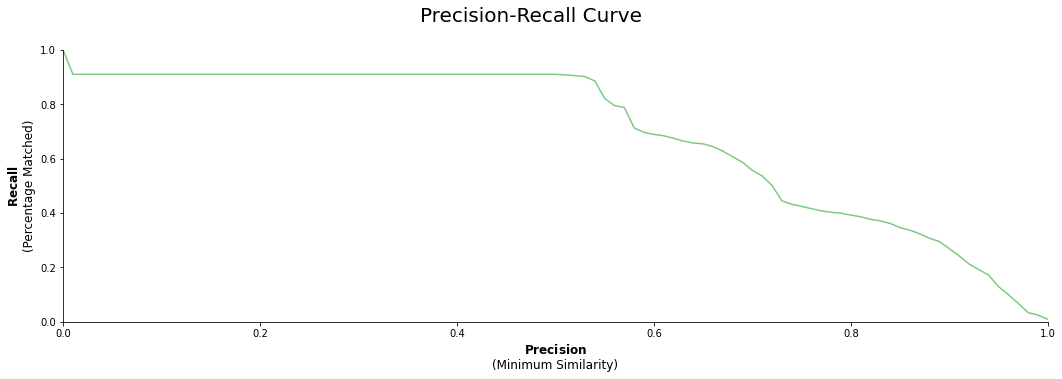

In [125]:
tfidf_model.visualize_precision_recall()

Faster than Fuzzywuzzy but not great in terms of performance - has some matching errors

Let's try BERT on 1 boro

In [126]:
from polyfuzz.models import EditDistance, TFIDF, Embeddings
from flair.embeddings import TransformerWordEmbeddings

embeddings = TransformerWordEmbeddings('bert-base-multilingual-cased')
bert = Embeddings(embeddings, min_similarity=0, model_id="BERT")
tfidf = TFIDF(min_similarity=0)
edit = EditDistance()

string_models = [bert, tfidf, edit]
model = PolyFuzz(string_models)
model.match(from_list, match_list)

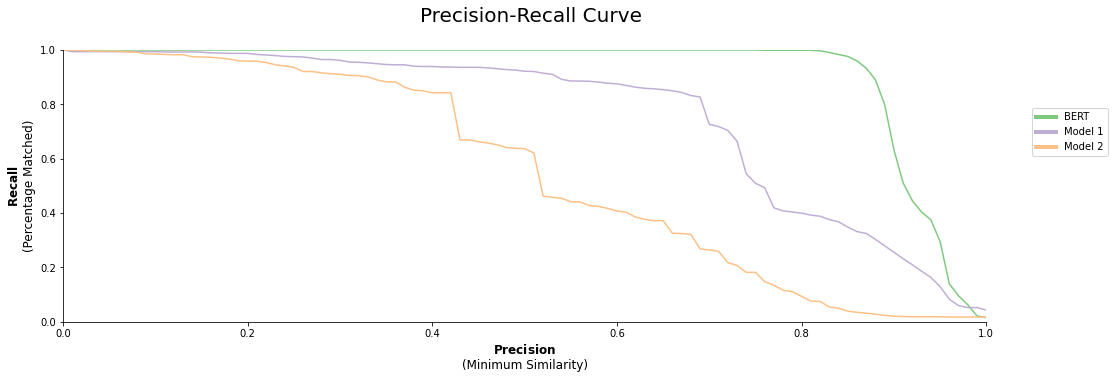

In [127]:
model.visualize_precision_recall()

In [133]:
model.get_matches('BERT').sample(60)

,From,To,Similarity
777,SQUADRON A ARMORY,S PINEHURST AVE,0.827877
214,WEST 99 STREET,WEST ST,0.899945
623,EAST 124 STREET,EAST 107 ST ESPLANADE,0.906746
134,EAST 20 STREET,EAST 107 ST ESPLANADE,0.876577
142,EAST 97 STREET,EAST 107 ST ESPLANADE,0.906500
869,NIKOLA TESLA CORNER,TRANSVERSE NUMBER FOUR,0.862709
298,WEST 164 STREET,W 181 STREET FOOTBRIDGE,0.907298
906,WASHINGTON MEWS,WASHINGTON MEWS,1.000000
253,EAST 96 STREET,EAST 107 ST ESPLANADE,0.905471
842,HARLEM LANE PLAYGROUND,CARDINAL HAYES PL,0.892577


Looks better than TF-IDF so we should use BERT but its is having trouble with West/East Number Streets

Will do data cleaning to fix this - steps as follows:

1. Replace EAST/WEST with E/W if there are numbers after
2. Change STREET to ST

In [178]:
import re

test='EAST 68 STREET'
result= re.sub(r"(EAST) ([0-9]+) (STREET)",'E \g<2> ST',test)
result

'E 68 ST'

In [249]:

ticket20_clean['Street1Clean']=ticket20_clean['Street1'].str.replace(' +',' ',regex=True)

ticket20_clean['Street1Clean']=ticket20_clean['Street1Clean'].str.replace(r"(EAST) ([0-9]+) (STREET)",'E \g<2> ST',regex=True)
ticket20_clean['Street1Clean']=ticket20_clean['Street1Clean'].str.replace(r"(WEST) ([0-9]+) (STREET)",'W \g<2> ST',regex=True)

In [250]:
ticket20_clean

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3,Street1Clean
0,1477633194,J58JKX,NJ,PAS,05/08/1972 12:00:00 AM,16,SDN,HONDA,P,08730,05130,05280,0,72.0,72,504,342924,T504,0000,0523P,None,K,F,270,43 ST,None,0,408,E2,None,YYYYYBB,0800A,0400P,BK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF308730,PF305130,PF305280,43 STREET,2 AVENUE,3 AVENUE,43 STREET
1,1449715424,KRE6058,PA,PAS,08/29/1977 12:00:00 AM,98,SUBN,ME/BE,P,86530,71800,73110,0,77.0,77,77,961115,0077,0000,0428P,None,K,F,1953,UNION ST,None,0,408,F1,None,BBBBBBB,ALL,ALL,BLK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF386530,PF371800,PF373110,UNION STREET,PORTAL STREET,RALPH AVENUE,UNION STREET
2,1455779155,444326R,NJ,PAS,10/03/1988 12:00:00 AM,20,SDN,LEXUS,P,27030,41330,69230,0,88.0,88,730,535422,T730,0000,0625A,None,K,O,45,CLERMONT AVENUE,None,0,408,D,None,BBBBBBB,ALL,ALL,BLACK,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF327030,PF341330,PF369230,CLERMONT AVENUE,FLUSHING AVENUE,PARK AVENUE,CLERMONT AVENUE
3,1458800908,F728330,OH,PAS,01/03/1990 12:00:00 AM,21,SDN,CHEVR,P,33030,93630,58730,0,90.0,90,301,355074,T301,0000,1106A,None,K,F,218,DIVISION AVE,None,0,408,C,None,BYBBYBB,1100A,1230P,None,0.0,0,-,0,None,None,NaN,NaN,NaN,3,PF333030,PF393630,PF358730,DIVISION AVENUE,WILSON STREET,MARCY AVENUE,DIVISION AVENUE
4,1466038676,FMY9090,NY,PAS,02/14/1990 12:00:00 AM,21,SUBN,JEEP,S,45130,23930,68130,20210915,90.0,90,0,668676,KNBO,0000,1253A,None,K,F,850,GRAND ST,None,0,408,D1,None,BYBBYBB,1200A,0300A,GREY,0.0,2015,-,0,None,None,NaN,NaN,NaN,3,PF345130,PF323930,PF368130,GRAND STREET,BUSHWICK AVENUE,OLIVE STREET,GRAND STREET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495727,1449651586,T64528C,NY,OMT,12/30/2031 12:00:00 AM,98,SUBN,CHEVR,P,49130,57330,75130,20191231,73.0,73,73,966289,0073,0000,1124A,None,K,F,1116,HERKIMER ST,None,0,408,J2,None,BBBBBBB,ALL,ALL,BLK,0.0,2013,-,0,None,None,NaN,NaN,NaN,3,PF349130,PF357330,PF375130,HERKIMER STREET,LOUIS PLACE,SARATOGA AVENUE,HERKIMER STREET
12495728,1455922523,GPJ7182,NY,PAS,06/25/2033 12:00:00 AM,21,SDN,HONDA,S,37110,24120,11710,0,33.0,33,0,589988,MN09,0000,1158A,None,None,O,465,WEST 167 STREET,None,0,408,D1,None,BYBBBBB,1130A,0100P,BLK,0.0,2011,-,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12495729,1458428930,62161MM,NY,COM,01/03/2040 12:00:00 AM,19,VAN,FORD,P,68020,26160,26190,0,40.0,40,0,361339,BXTE,0000,1111A,None,BX,F,2897,3RD AVE,None,0,408,E9,None,BBBBBBB,ALL,ALL,BR,0.0,2019,-,0,None,None,NaN,NaN,NaN,2,PF268020,PF226160,PF226190,3 AVENUE,EAST 150 STREET,EAST 151 STREET,3 AVENUE
12495731,1446438314,HNY4802,NY,PAS,01/17/2049 12:00:00 AM,40,P-U,FORD,P,47520,77150,22920,20210327,49.0,49,49,949429,0049,0000,0210A,None,BX,F,719,LYDIG AVE,None,0,408,K4,None,BBBBBBB,ALL,ALL,GY,0.0,2005,-,0,None,None,NaN,NaN,NaN,2,PF247520,PF277150,PF222920,LYDIG AVENUE,WHITE PLAINS ROAD,CRUGER AVENUE,LYDIG AVENUE


In [251]:
from_list_b1=ticket20_clean[ticket20_clean['Boro Code']=='1']['Street1Clean'].dropna().unique().tolist()

In [252]:
embeddings = TransformerWordEmbeddings('bert-base-multilingual-cased')
bert = Embeddings(embeddings, min_similarity=0, model_id="BERT")
tfidf = TFIDF(min_similarity=0)
edit = EditDistance()

string_models = [bert, tfidf, edit]
model = PolyFuzz(string_models)
model.match(from_list_b1, match_list)

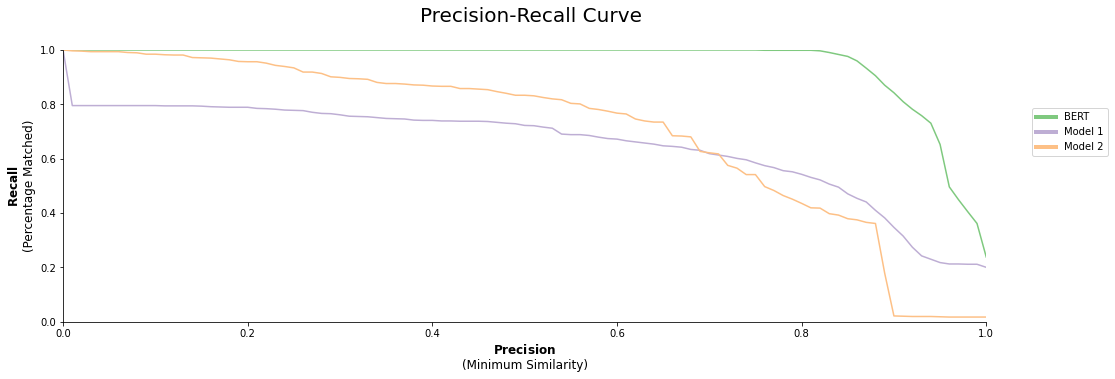

In [253]:
model.visualize_precision_recall()

In [259]:
model.get_matches('BERT').sample(50)

,From,To,Similarity
376,W 191 ST,W 191 ST,1.000000
751,COMMERCE STREET,COMMERCE ST,0.955977
915,FT TRYON PLACE,FT TRYON PL,0.969281
80,MAIDEN LANE,MAIDEN LN,0.871190
303,JAY STREET,JAY ST,0.935982
79,JOE DIMAGGIO HIGHWAY,JOHN HUSTON FINLEY WALK,0.902078
753,STATE STREET PLAZA,PLATT ST,0.912128
484,BLEECKER STREET,BLEECKER ST,0.959997
538,W 176 ST,W 176 ST,1.000000
394,E 129 ST,E 129 ST,1.000000


In [271]:
# Create seperate from and to list by Boro for better match accuracy

from_list_b2=ticket20_clean[ticket20_clean['Boro Code']=='2']['Street1Clean'].dropna().unique().tolist()
match_list_b2 = cl_df[cl_df['BOROCODE']==2]['FULL_STREE'].unique().tolist()
from_list_b3=ticket20_clean[ticket20_clean['Boro Code']=='3']['Street1Clean'].dropna().unique().tolist()
match_list_b3 = cl_df[cl_df['BOROCODE']==3]['FULL_STREE'].unique().tolist()
from_list_b4=ticket20_clean[ticket20_clean['Boro Code']=='4']['Street1Clean'].dropna().unique().tolist()
match_list_b4 = cl_df[cl_df['BOROCODE']==4]['FULL_STREE'].unique().tolist()
from_list_b5=ticket20_clean[ticket20_clean['Boro Code']=='5']['Street1Clean'].dropna().unique().tolist()
match_list_b5 = cl_df[cl_df['BOROCODE']==5]['FULL_STREE'].unique().tolist()

In [272]:
# Pipeline to run Bert/tfidf/edit for each boro

embeddings = TransformerWordEmbeddings('bert-base-multilingual-cased')
bert = Embeddings(embeddings, min_similarity=0, model_id="BERT")
tfidf = TFIDF(min_similarity=0)
edit = EditDistance()

string_models = [bert, tfidf, edit]
model_b2 = PolyFuzz(string_models)
model_b2.match(from_list_b2, match_list_b2)

model_b3 = PolyFuzz(string_models)
model_b3.match(from_list_b3, match_list_b3)

model_b4 = PolyFuzz(string_models)
model_b4.match(from_list_b4, match_list_b4)

model_b5 = PolyFuzz(string_models)
model_b5.match(from_list_b5, match_list_b5)

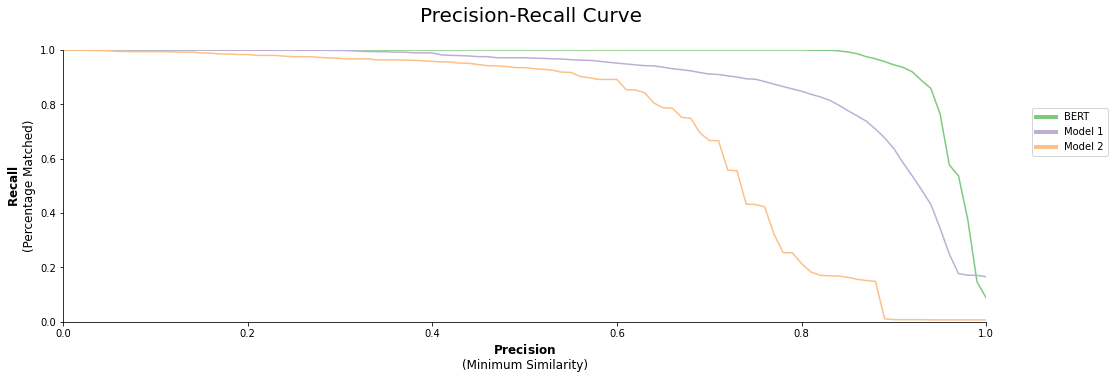

In [273]:
model_b2.visualize_precision_recall()

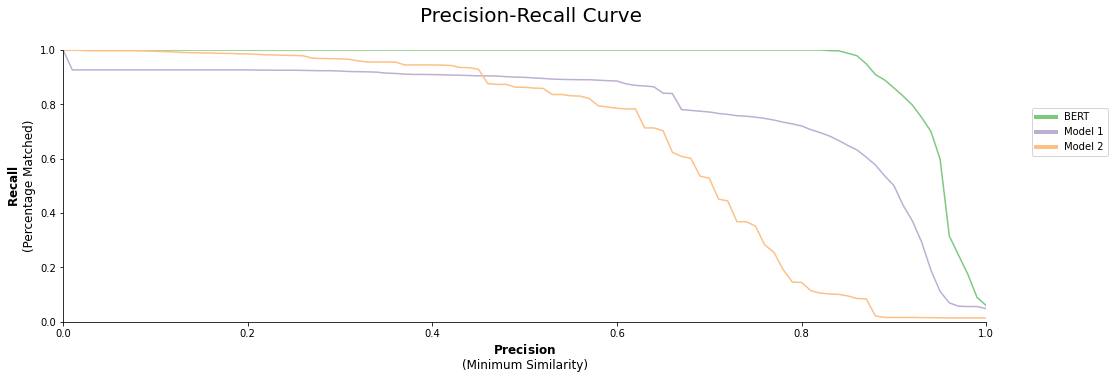

In [274]:
model_b3.visualize_precision_recall()

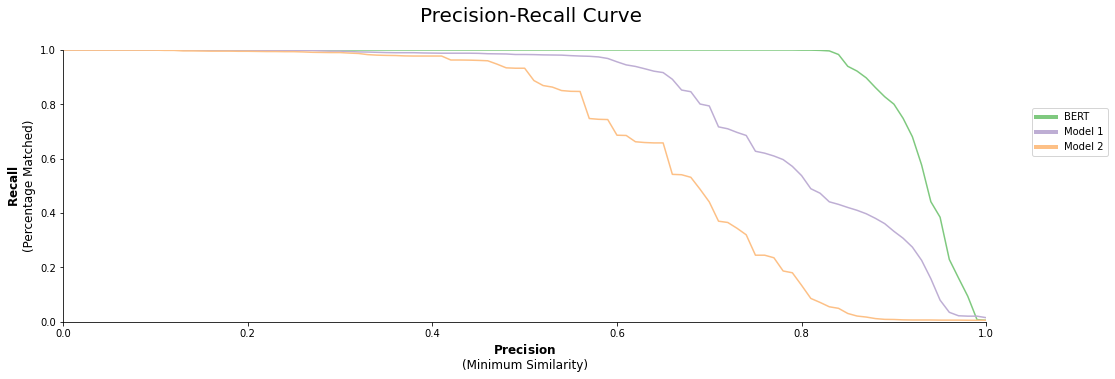

In [275]:
model_b4.visualize_precision_recall()

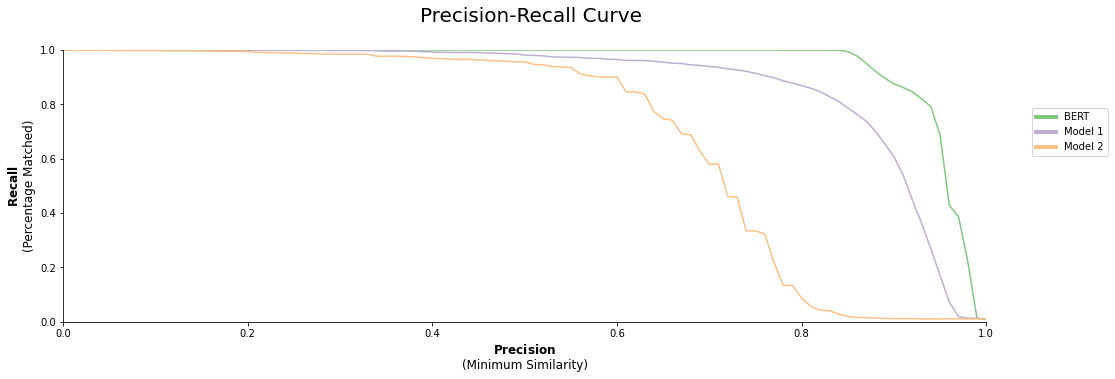

In [276]:
model_b5.visualize_precision_recall()

In [279]:
model_b5.get_matches('BERT').sample(10)

,From,To,Similarity
871,SAMUEL PLACE,SAMUEL PL,0.963943
1620,HEREFORD STREET,HEREFORD ST,0.957676
1400,DONGAN STREET,DONGAN ST,0.956553
1249,CYPRESS AVENUE,CYPRESS AVE,0.980555
1576,YALE STREET,YALE ST,0.949203
496,OAKLAND AVENUE,OAKLAND AVE,0.981098
935,SEYMOUR AVENUE,SEYMOUR AVE,0.980879
2374,BRANDIS LANE,BRANDIS AVE,0.865834
1989,CARLTON COURT,COVINGTON CIR,0.887790
1654,ST JULIAN PLACE,ST JULIAN PL,0.965430


In [283]:
model_b2.get_matches('BERT').sample(10)

,From,To,Similarity
965,MUNDY LANE,LANDING WAY,0.846101
994,GERBER PLACE,GERBER PL,0.952663
900,W 177 ST,W 177 ST,1.000000
572,E 186 ST,E 186 ST,1.000000
860,PUTNAM PLACE,PUTNAM PL,0.945859
1104,WHITTEMORE AVENUE,WHITTEMORE AVE,0.981652
467,HERING AVENUE,HERING AVE,0.981523
587,CLOSE AVENUE,CLOSE AVE,0.976017
956,LAKEVIEW PLACE,LAKEWOOD PL,0.945999
248,KAPPOCK STREET,KAPPOCK ST,0.944611


## For checking 

In [289]:
checkstring='MUNDY'

In [286]:
check_ticket= ticket20_clean.copy()
check_ticket.dropna(subset=['Street1'],inplace=True)
check_ticket[check_ticket['Street1Clean'].str.contains(checkstring)]

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Boro Code,Street1LU,Street2LU,Street3LU,Street1,Street2,Street3,Street1Clean
423492,8749763878,HGA1905,NY,PAS,07/08/2019 12:00:00 AM,71,4DSD,BMW,T,53020,40404,40404,20200418,47.0,47,47,366474,T201,C,0226P,None,BX,O,4239,Mundy Ln,None,0,408,J3,None,YYYYYYY,None,None,TN,NaN,2011,None,0,A,None,NaN,NaN,NaN,2,PF253020,PF240404,PF240404,MUNDY LANE,NaN,NaN,MUNDY LANE
694650,8764301151,HPP1450,NY,PAS,07/15/2019 12:00:00 AM,70,4DSD,BMW,T,53020,53720,28860,20190326,47.0,47,47,368539,T201,K,0246P,None,BX,F,4435,Mundy Ln,None,0,408,J6,None,YYYYYYY,None,None,BK,NaN,2007,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
694651,8764301140,HPP1450,NY,PAS,07/15/2019 12:00:00 AM,71,4DSD,BMW,T,53020,53720,28860,20190326,47.0,47,47,368539,T201,K,0245P,None,BX,F,4435,Mundy Ln,None,0,408,J6,None,YYYYYYY,None,None,BK,NaN,2007,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
1921788,8651141944,HPP1450,NY,PAS,08/13/2019 12:00:00 AM,70,4DSD,BMW,T,53020,53720,28860,20190326,47.0,47,47,365329,T201,R,0607P,None,BX,F,4439,Mundy Ln,None,0,408,C,None,YYYYYYY,None,None,BK,NaN,2007,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
2517790,8761516089,CAW3629,NY,PAS,08/27/2019 12:00:00 AM,71,SUBN,CHEVR,T,53020,53720,28860,20201024,47.0,47,47,365356,T201,N,0908A,None,BX,F,4439,Mundy Ln,None,0,408,J6,None,YYYYYYY,None,None,RD,NaN,2001,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
2517791,8761516077,HPP1450,NY,PAS,08/27/2019 12:00:00 AM,71,4DSD,BMW,T,53020,53720,28860,20190326,47.0,47,47,365356,T201,N,0907A,None,BX,F,4435,Mundy Ln,None,0,408,J3,None,YYYYYYY,None,None,BK,NaN,2007,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
2517792,8761516065,HPP1450,NY,PAS,08/27/2019 12:00:00 AM,70,4DSD,BMW,T,53020,53720,28860,20190326,47.0,47,47,365356,T201,N,0906A,None,BX,F,4435,Mundy Ln,None,0,408,C3,None,YYYYYYY,None,None,BK,NaN,2007,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
2519674,8761769472,GKD9927,NY,PAS,08/27/2019 12:00:00 AM,40,SUBN,HONDA,T,53020,53720,28860,20190917,47.0,47,47,358563,T201,S,0907A,None,BX,F,4423,Mundy Ln,None,0,408,J2,None,YYYYYYY,None,None,GY,NaN,2011,None,0,G,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
2519675,8761769460,HUX4815,NY,PAS,08/27/2019 12:00:00 AM,74,4DSD,INFIN,T,53020,53720,28860,20190830,47.0,47,47,358563,T201,S,0905A,None,BX,F,4409,Mundy Ln,None,0,408,J6,None,YYYYYYY,None,None,BK,NaN,2014,None,0,G,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE
3278502,8761520160,JHA5225,NY,PAS,09/13/2019 12:00:00 AM,46,CONV,BMW,T,53020,53720,28860,20210424,47.0,47,47,365356,T201,N,0727A,None,BX,F,4423,Mundy Ln,None,0,408,J2,None,YYYYYYY,None,None,BK,NaN,2003,None,0,47,None,NaN,NaN,NaN,2,PF253020,PF253720,PF228860,MUNDY LANE,NEREID AVENUE,EAST 241 STREET,MUNDY LANE


In [290]:
cl_df[cl_df['ST_LABEL'].str.contains(checkstring)]

,the_geom,L_LOW_HN,PHYSICALID,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng,l_lowadd,l_highadd,r_lowadd,r_highadd,c_lowadd,c_highadd
2947,MULTILINESTRING ((-73.83927240498485 40.898660...,NaN,190502,NaN,NaN,NaN,10466.0,NaN,1522603413,1522601129,MUNDY LN,2,NaN,2,24,11/29/2007 12:00:00 AM +0000,03/12/2021 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,760.337690,NaN,NaN,NaN,NaN,NaN,NaN
16615,MULTILINESTRING ((-74.12864096518541 40.623654...,111,190553,125,110,122,10310.0,10310.0,1622610599,1622607112,MUNDY AVE,2,NaN,5,32,11/29/2007 12:00:00 AM +0000,03/15/2021 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,MUNDY AVE,MUNDY,NaN,346.899466,111.0,125,110.0,122,110.0,125.0
18071,MULTILINESTRING ((-73.83966433211837 40.897885...,NaN,95065,NaN,NaN,NaN,10466.0,NaN,1522603413,1522609126,MUNDY LN,2,NaN,2,24,11/29/2007 12:00:00 AM +0000,03/12/2021 12:00:00 AM +0000,TW,1,13,13,C,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,302.449668,NaN,NaN,NaN,NaN,NaN,NaN
46394,MULTILINESTRING ((-74.12920250196248 40.626540...,1,59294,63,2,72,10310.0,10310.0,1622603432,1622606872,MUNDY AVE,2,NaN,5,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TF,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,MUNDY AVE,MUNDY,NaN,693.157272,1.0,63,2.0,72,1.0,72.0
53043,MULTILINESTRING ((-74.12876748765376 40.624667...,NaN,59293,NaN,NaN,NaN,10310.0,10310.0,1622608678,1622607081,MUNDY AVE,2,NaN,5,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,MUNDY AVE,MUNDY,NaN,91.030907,NaN,NaN,NaN,NaN,NaN,NaN
53936,MULTILINESTRING ((-73.84113152789418 40.903503...,4529,172803,4537,0,0,10466.0,NaN,1522610803,1522601174,MUNDY LN,2,NaN,2,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,253.765187,4529.0,4537,NaN,0,4529.0,4537.0
69328,MULTILINESTRING ((-73.84004474701781 40.900574...,4401,172805,4427,0,0,10466.0,NaN,1522612464,1522601129,MUNDY LN,2,NaN,2,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,345.585156,4401.0,4427,NaN,0,4401.0,4427.0
85017,MULTILINESTRING ((-74.12874146686885 40.624418...,65,59292,89,74,90,10310.0,10310.0,1622608678,1622603618,MUNDY AVE,2,NaN,5,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,AVE,NaN,NaN,MUNDY AVE,MUNDY,NaN,125.366972,65.0,89,74.0,90,65.0,90.0
88403,MULTILINESTRING ((-73.84102047408975 40.902814...,4501,95063,4527,0,0,10466.0,NaN,1522610803,1522601174,MUNDY LN,2,NaN,2,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,253.414934,4501.0,4527,NaN,0,4501.0,4527.0
109927,MULTILINESTRING ((-73.84065327457559 40.901403...,4429,172808,4499,0,0,10466.0,NaN,1522612464,1522601129,MUNDY LN,2,NaN,2,30,11/29/2007 12:00:00 AM +0000,08/28/2020 12:00:00 AM +0000,TW,1,13,13,S,NaN,NaN,NaN,LN,NaN,NaN,MUNDY LN,MUNDY,NaN,527.052089,4429.0,4499,NaN,0,4429.0,4499.0


In [291]:
stnames[stnames['Street Name'].str.contains(checkstring)]

,Raw,Street Name,Lookup
35271,12MUNDY LANE PF2530200101...,MUNDY LANE,PF253020
100780,15MUNDY AVENUE PF5446550101...,MUNDY AVENUE,PF544655


## Thoughts on BERT

Will likely have to do a similarity cut off then "manually" check those that have a lot of tickets - BERT can do a bulk of the heavy lifting but does miss some easy one

In [42]:
cl_gjson['pid']=cl_gjson['features'].str['properties'].str['physicalid'].astype(int)

cl_gjson.sort_values(by=['pid'],inplace=True)

In [ ]:
first_line = MultiLineString([row1])
first_line

In [ ]:
second_line = MultiLineString([row2])
second_line

In [ ]:
combined =MultiLineString([row1,row2])
combined

In [ ]:
cl_gjson[(cl_gjson['street'].str.contains('BROADWAY'))&(cl_gjson['borocode']=='1')]

In [ ]:
cl_gjson[(cl_gjson['street']=='BROADWAY')&(cl_gjson['borocode']=='1')&(cl_gjson['roadtype']=='1')]

In [ ]:
GRAND STREET	BUSHWICK AVENUE	OLIVE STREET

In [43]:
ave3 = []
for i in cl_gjson[(cl_gjson['street']=='GRAND ST')&(cl_gjson['borocode']=='3')&(cl_gjson['roadtype']=='1')]['coords']:
    print (i[0])
    ave3.append(i[0][0])
    
e17st = []
for i in cl_gjson[(cl_gjson['street']=='BUSHWICK AVE')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e17st.append(i[0][0])
    
e18st = []
for i in cl_gjson[(cl_gjson['street']=='OLIVE ST')&(cl_gjson['borocode']=='3')]['coords']:
    print (i[0])
    e18st.append(i[0][0])

[[-73.96665848169509, 40.71635918368772], [-73.96609959111777, 40.716206112640855]]
[[-73.96677983767256, 40.71642538837487], [-73.96665848169509, 40.71635918368772]]
[[-73.96609959111777, 40.716206112640855], [-73.96447229927665, 40.71573310595641]]
[[-73.96447229927665, 40.71573310595641], [-73.96277758654267, 40.715106634804386]]
[[-73.96277758654267, 40.715106634804386], [-73.96128719656062, 40.71450229696462]]
[[-73.96128719656062, 40.71450229696462], [-73.95979763206105, 40.713887133734545]]
[[-73.95979763206105, 40.713887133734545], [-73.95834207509, 40.71330630064778]]
[[-73.95834207509, 40.71330630064778], [-73.95680951657143, 40.712756388272865]]
[[-73.95680951657143, 40.712756388272865], [-73.955475961298, 40.71226542569624]]
[[-73.93317899912154, 40.71379901901624], [-73.9323301595279, 40.71400996318601]]
[[-73.93480281865519, 40.713372495593696], [-73.93317899912154, 40.71379901901624]]
[[-73.93724803605217, 40.71278274129178], [-73.93480281865519, 40.713372495593696]]
[[-

In [ ]:
ave3 = [x[::-1] for x in ave3[0]]
ave3

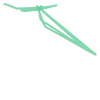

In [44]:
mls=MultiLineString([
   ave3,e17st,e18st
])

mls

In [45]:
line1=MultiLineString([ave3])
line2=MultiLineString([e17st])
line3=MultiLineString([e18st])
mylines = [line1,line2,line3]

In [ ]:
res1=line1.intersection(line2)
res1

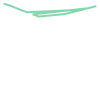

In [46]:
line1

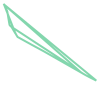

In [47]:
line2

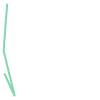

In [48]:
line3

In [ ]:
full_coords

In [ ]:
test_list

In [ ]:
cl_df[cl_df['ST_LABEL']=='84 ST']

In [ ]:


cl_gjson.loc[0]['features']

In [ ]:
import psycopg2

connection = psycopg2.connect(database='nyc_gis',user='stuart',password='stuart')
cursor = connection.cursor()
cursor.execute("CREATE TABLE street_data (id SERIAL PRIMARY KEY,stname VARCHAR(255),borocode INT, roadtype INT,shape GEOMETRY)")

In [ ]:
connection.commit()

In [ ]:
from shapely.geometry import MultiLineString
from shapely import geometry, ops

test=cl_gjson.loc[0]['features']['geometry']['coordinates']
test_list=[]
for i in test[0]:
    coord = (i[0],i[1])
    test_list.append(coord)
    
test_list

test2=cl_gjson.loc[2]['features']['geometry']['coordinates']
test_list2=[]
for i in test2[0]:
    coord = (i[0],i[1])
    test_list2.append(coord)
    
test_list2

In [ ]:


mls=MultiLineString([
   test_list,test_list2
])


In [ ]:
mls

In [ ]:
cl_gjson[cl_gjson['street']=='STERLING PL']

In [ ]:
from shapely.geometry import MultiLineString
from itertools import combinations

multiline=cl_gjson[cl_gjson['street']=='STERLING PL']['coords']
multiline

In [ ]:
for line1, line2 in combinations([line for line in multiline],2):
    if line1.intersects(line2):
        print(line1.intersection(line2))

In [ ]:
test=cl_df[(cl_df['FULL_STREE'].str.contains('63 ST')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()

In [ ]:
test

In [ ]:
cl_df[(cl_df['FULL_STREE'].str.contains('2 AVE')) & (cl_df['BOROCODE']==1) & (cl_df['RW_TYPE']==1)]['the_geom'].values.tolist()